#### Version: 1.0

#### Environment: Python 3.6 and Jupyter notebook
<B><font size=3 color="green">
Libraries used: 
* Pandas to Dataframe usage and data manipulation 
* json to load json file
* Math - Functions
* Xml tree to load Xml file
* Numpy for data manipulation
* Seaborn for plots
* matplotlib for plots
* statsmodels
* statsmodels.formula.api 
* statsmodels.graphics.gofplots for plots
* Shapefile to load Shapefile 
    
</B></font>

In [152]:
#Importing required libraries
import pandas as pd
import json
from math import sin, cos, sqrt, atan2, radians
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
from shapely.geometry import Point, shape,Polygon
import shapefile

## 1. Data Integration 

<br/>
<B><font size=3 color="green">In this section We integrate Real estate data with Hospitals,Shopping Centres, Super Markets,Suburbs and Train information.</font></B>

### 1.1 Reading Real estate Data- Json

In [153]:
# Reading the file
with open('real_state.json') as f:
    data = json.load(f)

In [154]:
#Converting into Dataframe
property_data_json = pd.DataFrame.from_dict(data, orient='columns')

In [155]:
# re-arranging the columns
property_data_json = property_data_json[['property_id', 'lat','lng','addr_street','price','year','property_type','bedrooms','bathrooms','parking_space']]

In [156]:
# Reading Xml Real Estate Data 
tree = ET.parse('real_state.xml')
root = tree.getroot()
properties_list = []
for i, child in enumerate(root):
    record = {}
    for subchild in child:
        record[subchild.tag] = subchild.text
    properties_list.append(record)
property_data_xml = pd.DataFrame(properties_list)
property_data_xml=property_data_xml.T
property_data_xml=property_data_xml.reset_index()
property_data_xml.drop('index', axis=1,inplace=True)
property_data_xml.columns=['bathrooms','price','bedrooms','parking_space','year','lat','lng','property_type','addr_street','property_id']
property_data_xml = property_data_xml[['property_id', 'lat','lng','addr_street','price','year','property_type','bedrooms','bathrooms','parking_space']]
property_data_xml=property_data_xml[property_data_xml['property_id']!='nan']
property_data_xml[['property_id', 'lat','lng','price','year','bedrooms','bathrooms','parking_space']] = property_data_xml[['property_id', 'lat','lng','price','year','bedrooms','bathrooms','parking_space']].apply(pd.to_numeric)

In [157]:
# Data Manipulation 
property_data=property_data_json.append(property_data_xml, ignore_index=True)
property_data.drop_duplicates(subset='property_id',inplace=True)
property_data=property_data.reset_index()
property_data.drop('index', axis=1,inplace=True)
property_data=property_data[pd.isna(property_data['property_id'])==False]

## 1.2 Shopping Centres
<br/>

<B><font size=3 color="green">In this section we wwill find nearest shopping centre to the property and add its ID and Distance to the Data</font></B>

In [158]:
#Loading Shopping Centre
shopping_centres=pd.read_html('shopingcenters.html')[0]
shopping_centres=shopping_centres.drop(['Unnamed: 0'],axis=1)

In [159]:
# Function to Calcuate Distance
def lat_log_dist(lat1,lon1,lat2,lon2):
    R = 6378
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c * 1000
    return distance

In [160]:
#Finding Nearest Shopping Centre
sc_id=[]
dist=[]
for i,j in property_data.iterrows():
    lat1=radians(property_data['lat'][i])
    lng1=radians(property_data['lng'][i])
    a=[]
    for index,row  in shopping_centres.iterrows():
        a.append((lat_log_dist(lat1,lng1,radians(shopping_centres['lat'][index]),radians(shopping_centres['lng'][index])),shopping_centres['sc_id'][index]))
    z=min(a)
    sc_id.append(z[1])
    dist.append(round(z[0],2))

property_data['shopping_center_id']=sc_id
property_data['distance_to_sc']=dist    

## 1.3 Train Information
<br/>
<B><font size=3 color="green">In this Section we will merge Melbourne GTFS Train Data with property Information . Basically we will find the nearest train station to Property and find the average travel time to Fliders street between 07AM-09AM. If there is no train between 7am-9am, we will find the nearest station which has train.Tranfer fld becomes 1 if there is train between 7-9 but its is not direct. Otherwise it is 0</font></B>  

In [161]:
#Loading all Melbourne GTFS data
stops=pd.read_csv('stops.txt',sep=",")
routes=pd.read_csv('routes.txt',sep=",")
stop_time=pd.read_csv('stop_times.txt',sep=",")
trips=pd.read_csv('trips.txt',sep=",")
calendar=pd.read_csv('calendar.txt',sep=",")
# Merging them into single DataFrame
result=routes.merge(trips,left_on='route_id',right_on='route_id',how='inner')
result=result.merge(stop_time,left_on='trip_id',right_on='trip_id',how='inner')
result=result.merge(stops,left_on='stop_id',right_on='stop_id',how='inner')
result=result.merge(calendar,left_on='service_id',right_on='service_id',how='inner')
result=result[result['service_id']=='T0']

In [162]:
# Finding the travel time of all direct trains to Fliders between 07-09AM . We know from the Data that stop_ID of Fliders =19854
stop_list=stops['stop_id'].tolist()

df_Direct_train = pd.DataFrame(columns = ['stop_id', 'time', 'flag'])
for each in stop_list:
    temp=result[result['stop_id'].isin([each,19854])]
    
    temp=temp[temp['trip_headsign']=='City (Flinders Street)']
    temp=temp[['route_id','trip_id','arrival_time','departure_time','stop_id']]
   
    temp1 = temp[temp['stop_id'] == 19854]
    temp2 = temp[(temp['stop_id'] != 19854) & (temp['departure_time']>='07:00:00') & (temp['departure_time']<='09:00:00')]
    
    temp3=temp1.merge(temp2,left_on=['route_id','trip_id'],right_on=['route_id','trip_id'],suffixes=('_1','_2'))
    
    #from datetime import datetime
    temp3['diif']=pd.to_datetime(temp3['arrival_time_1'])-pd.to_datetime(temp3['departure_time_2'])
    temp3['diff1']=temp3['diif'].dt.total_seconds()/60
    l = len(df_Direct_train)
    df_Direct_train.at[l, 'time'] = round(temp3['diff1'].mean(),2)
    df_Direct_train.at[l, 'stop_id'] = each
    df_Direct_train.at[l, 'flag'] = 0


In [163]:
#Handling Indrect train Transfers
time = 0
stop_direct = 0
for i in df_Direct_train[(df_Direct_train['time'].isna()) & (df_Direct_train['stop_id']!= 19854)].index:
    stop = df_Direct_train.loc[i]['stop_id']
    df_temp = result[(result['stop_id']==stop) & (result['departure_time']>='07:00:00') & (result['departure_time']<='09:00:00')]
    for j in df_temp.index:
        if result.loc[j]['stop_id'] == stop:
            route = result.loc[j]['route_long_name']
            list_stop = result[result['route_long_name'] == route]['stop_id']
            for each in list_stop:
               
                for idx in result[result['stop_id']==each].index:
                    if result.loc[idx]['trip_headsign'] == 'City (Flinders Street)':
                        stop_direct = result.loc[idx]['stop_id']
                        time = df_Direct_train.loc[df_Direct_train['stop_id']==stop_direct]['time'].item()
                        
    
    temp=result[(result['stop_id'].isin([stop,stop_direct])) &  (result['direction_id'] == 0)]
    
    temp=temp[['route_id','trip_id','arrival_time','departure_time','stop_id']]
    temp1 = temp[temp['stop_id'] ==stop_direct]
    temp2 = temp[(temp['stop_id'] == stop)  & (temp['departure_time']>='07:00:00') & (temp['departure_time']<='09:00:00')]
    
    temp3=temp1.merge(temp2,left_on=['route_id','trip_id'],right_on=['route_id','trip_id'],suffixes=('_1','_2'), how = 'right')
    
    temp3['diif']=pd.to_datetime(temp3['arrival_time_1'])-pd.to_datetime(temp3['departure_time_2'])
    temp3['diff1']=temp3['diif'].dt.total_seconds()/60
    df_Direct_train.at[i, 'time'] = round(temp3['diff1'].mean(),2)+time
    df_Direct_train.at[i, 'flag'] = 1


In [164]:
# Making the flag as 0 for fliders street Station Id
index = df_Direct_train.loc[df_Direct_train['stop_id']== 19854].index
df_Direct_train.at[index, 'time'] = 0
df_Direct_train[['stop_id','time','flag']] = df_Direct_train[['stop_id','time','flag']].apply(pd.to_numeric)


In [165]:
#merging with stops 
stops_temp=stops.merge(df_Direct_train,left_on=['stop_id'],right_on=['stop_id'],how='inner')
# Finding distance,transfer Flag,Average travel time and stopid
stop_id=[]
dist=[]
time=[]
flag=[]
for i,j in property_data.iterrows():
    lat1=radians(property_data['lat'][i])
    lng1=radians(property_data['lng'][i])
    a=[]
    for index,row  in stops_temp.iterrows():
        a.append((lat_log_dist(lat1,lng1,radians(stops_temp['stop_lat'][index]),radians(stops_temp['stop_lon'][index])),stops_temp['stop_id'][index],stops_temp['time'][index],stops_temp['flag'][index]))
    z=min(a)
    stop_id.append(z[1])
    dist.append(round(z[0],2))
    flag.append(z[3])
    time.append(z[2])
property_data['train_station_id']=stop_id
property_data['distance_to_train_station']=dist
property_data['travel_min_to_CBD']=time
property_data['transfer_flag']=flag 

## 1.4 Hospitals Data
<br/>
<B><font size=3 color="green">
In this section we will find the nearest Hospital to property and merge it with the property data along with Hospital ID and  Min distance.</font></B>

In [166]:
#Reading Hospital Data
with open('hospitals.json') as f:
    data = json.load(f)
hospitals_json = pd.DataFrame.from_dict(data, orient='columns')

In [167]:
# Finding Minimum Distance 
hosp_id=[]
dist=[]
for i,j in property_data.iterrows():
    lat1=radians(property_data['lat'][i])
    lng1=radians(property_data['lng'][i])
    a=[]
    for index,row  in hospitals_json.iterrows():
        a.append((lat_log_dist(lat1,lng1,radians(hospitals_json['lat'][index]),radians(hospitals_json['lng'][index])),hospitals_json['id'][index]))
    z=min(a)
    hosp_id.append(z[1])
    dist.append(round(z[0],2))

property_data['hospital_id']=hosp_id
property_data['distance_to_hospital']=dist

## 1.5 Super Markets Data
<br/>

<B><font size=3 color="green">In this section we will find the nearest Supermarkets and merge it with property. </font></B>

In [168]:
#Reading Super Market Data
super_markets = pd.read_excel('supermarkets.xlsx', sheet_name=None)
super_markets=pd.read_excel('supermarkets.xlsx', index_col=None)

In [169]:
#Finding Nearest Super Market
super_markets_id=[]
dist=[]
for i,j in property_data.iterrows():
    lat1=radians(property_data['lat'][i])
    lng1=radians(property_data['lng'][i])
    a=[]
    for index,row  in super_markets.iterrows():
        a.append((lat_log_dist(lat1,lng1,radians(super_markets['lat'][index]),radians(super_markets['lng'][index])),super_markets['id'][index]))
    z=min(a)
    super_markets_id.append(z[1])
    dist.append(round(z[0],2))

property_data['supermarket_id']=super_markets_id
property_data['distance_to_supermaket']=dist

### 1.6 Suburbs Data
<br/>
<B><font size=3 color="green">In this section we will merge suburbs name based on the given latitude and longitute of the properties </font></br>

In [170]:
#Reading Shape File
sf = shapefile.Reader("VIC_LOCALITY_POLYGON_shp.shp") 
recs = sf.records()
shapes = sf.shapes()

In [171]:
#Finding the suburbs using Shapely package
flag=False
suburb=[]
for index,row in property_data.iterrows():
    lnglog=Point(property_data['lng'][index],property_data['lat'][index])
    for i in range(len(shapes)):
        if Polygon(shapes[i].points).contains(lnglog):
            suburb.append(recs[i][6])
            flag=True
            break
    if flag == False:
        suburb.append('NotFound')

In [172]:
property_data['suburb']=suburb

In [173]:
for i,j in property_data.iterrows():
    if math.isnan(property_data['travel_min_to_CBD'][i]):
        lat=radians(property_data['lat'][i])
        lng=radians(property_data['lng'][i])
        lat_20025=radians(-37.801083)
        lng_20025=radians(144.903199)
        property_data['distance_to_train_station'][i]=lat_log_dist(lat,lng,lat_20025,lng_20025)        
        property_data['travel_min_to_CBD'][i]=14.15
        property_data['train_station_id'][i]=20025
        property_data['transfer_flag'][i]=0

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying t

In [174]:
property_data = property_data[['property_id', 'lat','lng','addr_street','suburb','price','year','property_type','bedrooms','bathrooms','parking_space',
                                'shopping_center_id', 'distance_to_sc','train_station_id','distance_to_train_station','travel_min_to_CBD','transfer_flag',
                               'hospital_id', 'distance_to_hospital','supermarket_id','distance_to_supermaket']]

In [175]:
property_data.to_csv('29416000_solution.csv')

## 2. Data Reshaping

<B><font size=3 color="green">Transformation refers to replacement of the variable by certain function of the variable.For instance replacing the variable x with logarithm of it or square root of it etc. In the correct sense  Transformation is a replacement that changes the shape of a distribution or relationship.<br/><br/>

There are several reasons for performing transformation.Few of them are,<br/>

   <li> Reducing Skewness </li>
   <li> Providing Equal spreads</li>
    <li>Easy for interpretation</li>
    <li>Better model performance</li>
   <li> Finding Relationship between variables.</li><br/>

We do all these data tranformation because it is easy for us to perform statistical analysis and Visualization.<br/><br/>A distribution which is symmetric and has equal variance/spread is quite easy to interpret results. <br/>

When we are concerned about the relationships between attributes ,it is more easier to interpret the patterns at are approximately linear than about patterns which are curved.<br/><br/>

In the below sections we will perform different transformation to see which one fits good for the given data.</font></B>
     

### 2.1 Price Distribution without any Transformation 

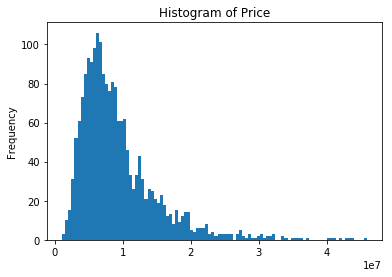

In [176]:
property_data['price'].plot(kind='hist',bins=100,title='Histogram of Price')

<B><font size=3 color="green">The above Histogram shows skewness in the price Data. Hence transforming them would be usefull for better visualisation.

Let us see the R-score value of this model without normalising and plot Q-Q plot and Vs Standard residuals </B>  

In [177]:
#Using OLS library to perform Linear Regression 
model_price = 'price ~ bedrooms+bathrooms+parking_space+property_type'
model = smf.ols(formula=model_price, data=property_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     46.91
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           2.80e-29
Time:                        21:42:57   Log-Likelihood:                -33417.
No. Observations:                1969   AIC:                         6.684e+04
Df Residuals:                    1965   BIC:                         6.686e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.394e+06   5.62e+05      6.043      0.000    2.29e+06    4.49e+06
bedrooms       1.163e+06   2.16e+05      5.398      0.000    7.41e+05    1.59e+06
bathrooms      1.205e+06   2.62e+05      4.599      0.000    6.91e+05    1.72e+06
parking_space  2.301e+05   1.73e+05      1.326      0.185    -1.1e+05     5.7e+05
==============================================================================
Omnibus:                      762.718   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3401.402
Skew:                           1.828   Prob(JB):                         0.00
Kurtosis:                       8.300   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<B><font size=3 color="green">The Model Score is less which is obvious as data is real and not all predictors are considered for the fit. The graph is right- skewed with co-efficient 1.828 and R-score value of 6.7%.


The Link below provides the code to plot QQ- Plots </B></font>

https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

In [178]:
#fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

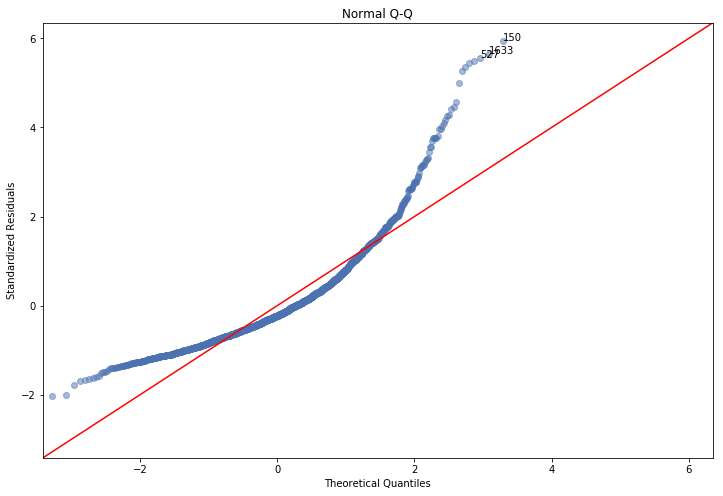

In [179]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

<B><font size=3 color="green">The graph above shows Quantiles Vs Standard residuals which is not fitting linearly. Hence we consider performing some transformations to achive good linear relationship.

Some of the tranformation we would like to use are 
    1. Zscore normalization 
    2. Log Normalization 
    3. Min-Max Normalization 
    4. Power Normalization 
 
As we dont have any Nulls or Negative values in the Price column all these methods would be good to use.</B></font>

### 2.2  Z-score Normalization  

<B><font size=3 color="green">Here we try to normalise the price feature to achieve normal Distribution.

Z score normalization is useful for comparing variables expressed in different units. Calculation of Z-score is given by the formula

Zscore doesn't change the distribution instead it normalises the units of measurement and helps to interpret the variances in different units </B></font>

<B><font color=Brown>Zscore=x-mean(x)/std(x) </font><B/>

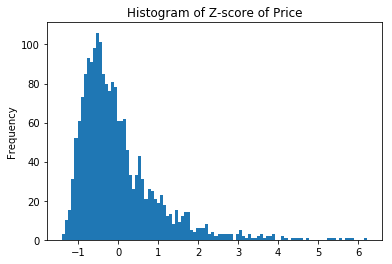

In [180]:
property_data['Zscore']=(property_data['price']-property_data['price'].mean())/property_data['price'].std()
property_data['Zscore'].plot(kind='hist',bins=100,title='Histogram of Z-score of Price')

<B><font size=3 color="green">The graph above shows the Histogram of Zscore of price which is still actually skewed. </B></font>

In [181]:
#Modelling with Z-score and Plotting Residuals
model_f = 'Zscore ~ bedrooms+bathrooms+parking_space+property_type'
model = smf.ols(formula=model_f, data=property_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Zscore   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     46.91
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           2.80e-29
Time:                        21:42:58   Log-Likelihood:                -2725.3
No. Observations:                1969   AIC:                             5459.
Df Residuals:                    1965   BIC:                             5481.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.0106      0.095    -10.588      0.000      -1.198      -0.823
bedrooms          0.1978      0.037      5.398      0.000       0.126       0.270
bathrooms         0.2049      0.045      4.599      0.000       0.118       0.292
parking_space     0.0391      0.029      1.326      0.185      -0.019       0.097
==============================================================================
Omnibus:                      762.718   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3401.402
Skew:                           1.828   Prob(JB):                         0.00
Kurtosis:                       8.300   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<B><font size=3 color="green">We can see that Skewness, R score and Kurtosis remains the same as original data and hence we proved that Z-score is only meant to interpret variables in different units and it doesn't change the distribution. </B></font> 

In [182]:
#fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

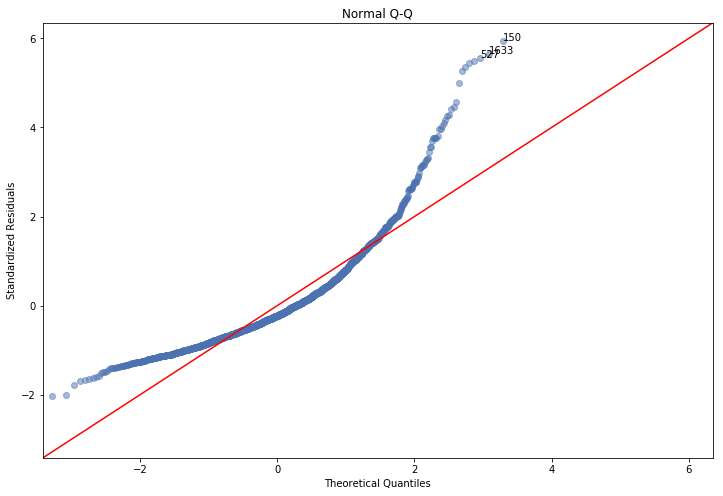

In [183]:
#PLotting QQ Plot 
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

<B><font size=3 color="green">We again see here there is no much difference between Actual Price and Z-scored prices.<B/></font>

### 2.3 Log Transformation

<B><font size=3 color="green">Log Transformation usually tranforms highly skewed data to less skewed. It changes the distribution shape, and it brings the extream outliers close to rest of data.We can achieve this by taking log(x) to base 10 or ln(x) on price column.<br/> The graph below shows the distribution when Log(x) to base 10 is applied on price column.

Log Transformation is used when the data is right skewed and log to base 10 works best when there are high values of data. In our case Price is right skewed and has high values, This should be good fit for the model. We shall prove this by plotting histogram and QQ plots</B></font>

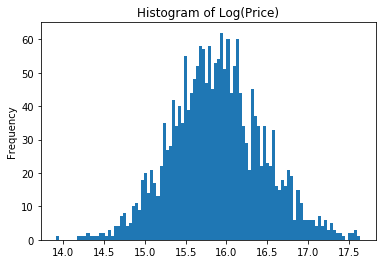

In [184]:
import math
property_data['logprice']=property_data['price'].apply(lambda x:math.log(float(x))) # converting it to float
property_data['logprice'].plot(kind='hist',bins=100,title='Histogram of Log(Price)')

<B><font size=3 color="green">Histogram shows the data is normally distributed</B></font>

In [185]:
#Fitting the model to check Static values
model_price = 'logprice ~ bedrooms+bathrooms+parking_space+property_type'
model = smf.ols(formula=model_price, data=property_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logprice   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     36.51
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           5.88e-23
Time:                        21:42:59   Log-Likelihood:                -1597.9
No. Observations:                1969   AIC:                             3204.
Df Residuals:                    1965   BIC:                             3226.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        15.3751      0.054    285.546      0.000      15.270      15.481
bedrooms          0.1109      0.021      5.369      0.000       0.070       0.151
bathrooms         0.0910      0.025      3.621      0.000       0.042       0.140
parking_space     0.0117      0.017      0.703      0.482      -0.021       0.044
==============================================================================
Omnibus:                        0.147   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.159
Skew:                           0.021   Prob(JB):                        0.924
Kurtosis:                       2.987   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<B><font size=3 color="green">We can see that Log Transformation has reduced skeweness with coefficient 0.021 in the data but there is also slight decrement in the R-Square value when compared to original data which is tradeoff. <br/><br/>


The below code is shows the QQ plot from which we can determine the linearity  </B></font>

In [186]:
#fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

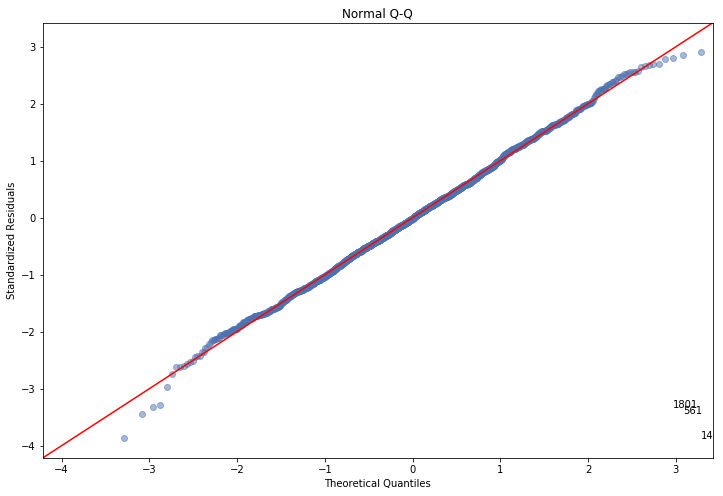

In [187]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

<B><font size=3 color="green">We can see from the above graph that Residuals Vs Quantiles have almost linear relationship. Hence this may be good fit. However we will see other transformation which may stil give better statistics.</B></font>  

### 2.4 Min-Max Normalization 

<B><font size=3 color="green">This tranformation is usefull when the distribution is not gaussian. As our distribution is gaussain this may not be good fit. We try to prove this below</B></font>

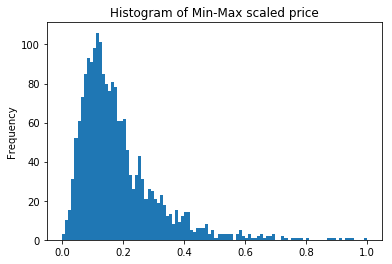

In [188]:
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler().fit(property_data[['price']])
property_data['minmax'] = minmax_scale.transform(property_data[['price']])
property_data['minmax'].plot(kind='hist',bins=100,title='Histogram of Min-Max scaled price')

<B><font size=3 color="green">The ditribution looks skewed again which is would be not efficient model to predict values.</B></font>

In [189]:
model_price = 'minmax ~ bedrooms+bathrooms+parking_space+property_type'
model = smf.ols(formula=model_price, data=property_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 minmax   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     46.91
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           2.80e-29
Time:                        21:43:01   Log-Likelihood:                 1272.1
No. Observations:                1969   AIC:                            -2536.
Df Residuals:                    1965   BIC:                            -2514.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0512      0.013      4.084      0.000       0.027       0.076
bedrooms          0.0260      0.005      5.398      0.000       0.017       0.035
bathrooms         0.0269      0.006      4.599      0.000       0.015       0.038
parking_space     0.0051      0.004      1.326      0.185      -0.002       0.013
==============================================================================
Omnibus:                      762.718   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3401.402
Skew:                           1.828   Prob(JB):                         0.00
Kurtosis:                       8.300   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [190]:
#fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

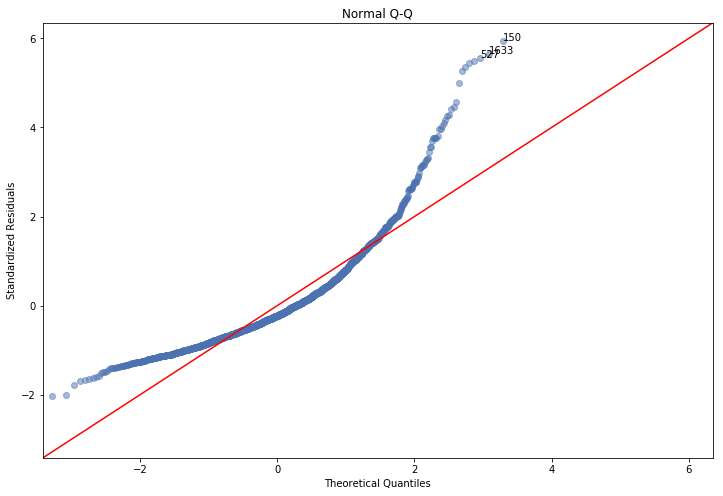

In [191]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

<B><font size=3 color="green">The Q-Q plot is not at all linear . Hence it not the best choice of normalization </B></font>

### 2.5 Power Transformation

#### 2.5.1 Square root of the function.

<B><font size=2 color="green">Square root tranformation is good for right Skewed distribution, Hence this may be good fit for our model.We shall determine this by plotting histograms and QQ-plot

Power transformation has moderate effect on the distribution shape. The below graph shows the distribution of square root function 
</B></font>

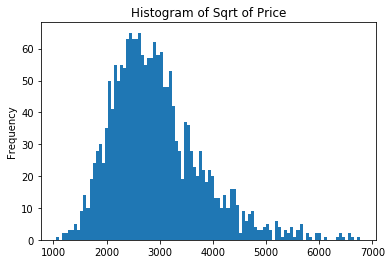

In [192]:
property_data['Power1_2']=pow(property_data['price'],0.5)
property_data['Power1_2'].plot(kind='hist',bins=100,title='Histogram of Sqrt of Price')

<B><font size=3 color="green">The Histogram looks approximately normal and it is slightly comparable to log transformation. We will the check the regression results to verify the skewness and R square values.</B></font>

In [193]:
model_price = 'Power1_2 ~ bedrooms+bathrooms+parking_space+property_type'
model = smf.ols(formula=model_price, data=property_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Power1_2   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     43.19
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           5.03e-27
Time:                        21:43:02   Log-Likelihood:                -16023.
No. Observations:                1969   AIC:                         3.205e+04
Df Residuals:                    1965   BIC:                         3.208e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2094.9625     81.813     25.607      0.000    1934.513    2255.412
bedrooms        171.9147     31.400      5.475      0.000     110.335     233.495
bathrooms       161.3582     38.175      4.227      0.000      86.491     236.226
parking_space    25.3399     25.273      1.003      0.316     -24.226      74.905
==============================================================================
Omnibus:                      230.768   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.180
Skew:                           0.853   Prob(JB):                     3.02e-75
Kurtosis:                       4.129   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<B><font size=3 color="green">The skeweness has reduced and also there is also slight improvement in R-Square. But we also need to look at the Residuals to decide on the best transformation. Hence we plot Q-Q plot of the Power transformation <B></font> 

In [194]:
#fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

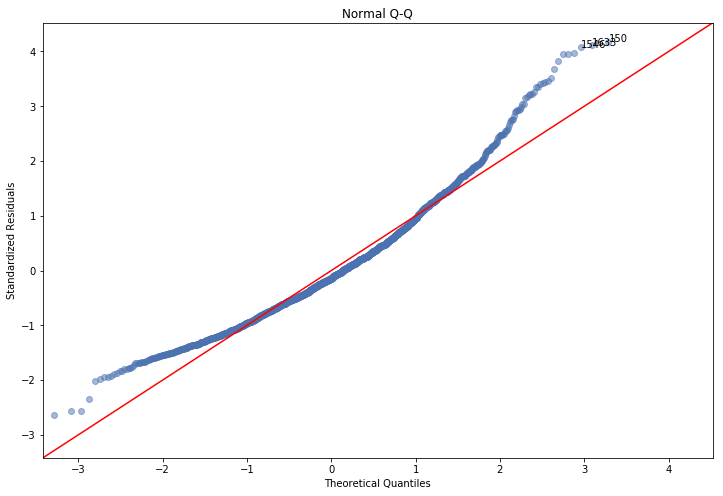

In [195]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

<B><font size=3 color="green">The Plot looks closely linear.However Log tranformations looks better when compared to this. </B></font>

#### 2.5.2 Square of the function.-Power(2)
<B><font size=2 color="green">This is usaully good when data is left skewed. But in our case price data is right skewed. Hence this may not effective. But we shall prove this by simply taking square of the price attribute. </B></font>

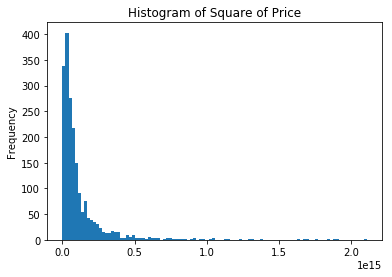

In [196]:
property_data['Power2']=pow(property_data['price'],2)
property_data['Power2'].plot(kind='hist',bins=100,title='Histogram of Square of Price')

<B><font size=3 color="green">Histogram is highy skewed and defintely wont be a good fit. But we shall prove this by the plot and the model.</B></font>

In [197]:
model_price = 'Power2 ~ bedrooms+bathrooms+parking_space+property_type'
model = smf.ols(formula=model_price, data=property_data)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Power2   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     42.92
Date:                Fri, 26 Oct 2018   Prob (F-statistic):           7.31e-27
Time:                        21:43:03   Log-Likelihood:                -67505.
No. Observations:                1969   AIC:                         1.350e+05
Df Residuals:                    1965   BIC:                         1.350e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.289e+13   1.85e+13     -3.392      0.001   -9.92e+13   -2.65e+13
bedrooms       3.342e+13   7.11e+12      4.698      0.000    1.95e+13    4.74e+13
bathrooms          4e+13   8.65e+12      4.625      0.000     2.3e+13     5.7e+13
parking_space  1.019e+13   5.73e+12      1.779      0.075   -1.05e+12    2.14e+13
==============================================================================
Omnibus:                     1855.049   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            76090.248
Skew:                           4.485   Prob(JB):                         0.00
Kurtosis:                      32.103   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<B><font size=3 color="green">The skewness has increased to 4.485 which suggests linear model wont fit as expected. </B></font>

In [198]:
#fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

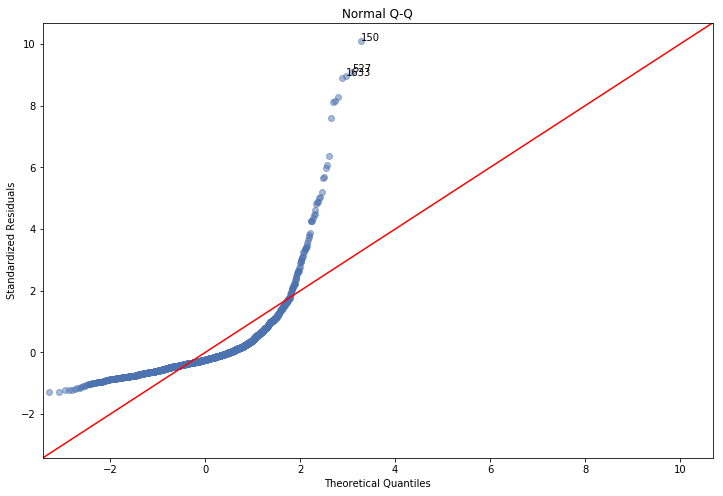

In [199]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

<B><font size=3 color="green">The plot residuals is not linear with the quantiles and hence will not be good fit.</B></font>

## 3. Linear Relation Model

<B><font size=3 color="green">Let us plot one of the mean predictor attributes to illustrate dependencies on log(price) and square root(price) and also we know it is linearly related.</B></font>

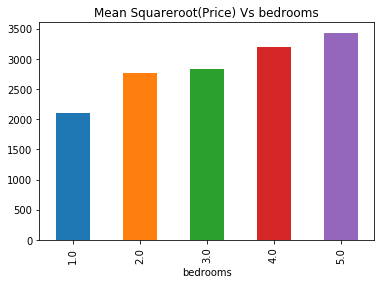

In [200]:
property_data.groupby('bedrooms').Power1_2.mean().plot(kind='bar',title='Mean Squareroot(Price) Vs bedrooms')

<B><font size=3 color="green">From the above Bar plot we can see as number of bedrooms increases price increases.</B></font>

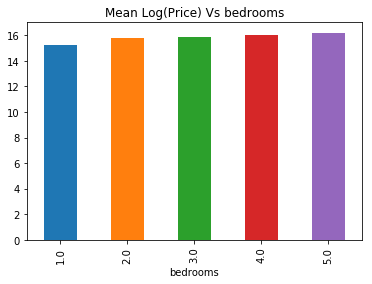

In [201]:
property_data.groupby('bedrooms').logprice.mean().plot(kind='bar', title='Mean Log(Price) Vs bedrooms')

<B><font size= 3 color="green">The above plot looks almost same for all.</B></font>

## 4. Conclusion 
<br/>

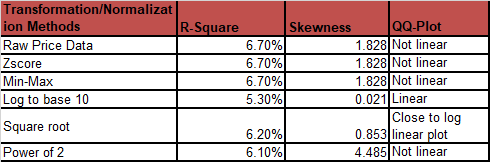

<B><font size=3 color="green">Infering from the above plotted histograms, log tranformation fits better to the normal distribution while square root tranformation looks close to log tranformation but it is more skewed than Log transformation. 
In our case for any Statistical analysis to be performed Log transformation would achieve better results than other tranformations analysed.

On the other hand if we are trying to find the linearity between variables square root transformations gives good visualization/scatter than the log tranformation which is evident from the above bar plots.

We cannot determine exactly what kind of transformation to be used as data is not huge and the predictors are not correctly defined(Evident from R-Square and P values )

The table above shows the summary of the Analysis made. There is always trade off between normal distribution and R-square value. IF  we need the data to be normally distributed then we have to compromise on variance and vice versa
<B></font>

## 5. Summary

<B><font size=3 color="green">The Assignement Task A aims are fullfilled. Firstly it merges Real Estate Data and Shopping centres to find nearest shopping centres to the property.Secondly closest Hosipital details and Super market details are merged with the property information.Finally GTFS Melbourne Train Travel information with nearest station and average Travel time to Flinders are measured and also Vic Suburbs Informations are  merged with property informations. <br/>

The Assginment Task B aims at performing Normalization/Transformation on Property Price column and deciding on which transformation would be best for linear model. As discussed in the above conclusion Log transformation would be best if Statistical parameters are analysed. If log is used to for linear model we may loose out spread of the data when transformed to log. In that case square root transformation performs better than Log.

On the whole it solely depends on the type of analysis performed for us to decide on the transformation. Over here neither the data doesn't contain as many as the records nor predictors are given correct. Therefore there is no conclusion !!

</B></font>

## 6. References

* https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034
* https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html